### Summery
<pre>
Author           : Anjana Tiha
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images by retraining pretrained model “InceptionV3” 
                      with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and Fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. Attained testing accuracy 83.44% and loss 0.42.
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 11.30.2018
Comments         : Please use Anaconda editor for convenience of visualization.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
GitLab Link      : <a href=https://gitlab.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitLab)</a>
Portfolio        : <a href=https://anjanatiha.wixsite.com/website>Anjana Tiha's Portfolio</a>
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

<!---
#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0
-->

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.15 Gigabyte (GB))
                          Training   : 5216 (1.07 Gigabyte (GB))
                          Validation : 320  (42.8 Megabyte (MB))
                          Testing    : 320  (35.4 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 50
Training Time           : 3 Hours

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<!--<b>Validation</b>-->
<b>Testing</b>
Accuracy                : 83.44%
Loss                    : 0.42
<!--Precision               : -->
Recall                  : 94% (highest)
<!--Specificity             : -->
</pre>

## Import Libraries

In [6]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, BatchNormalization
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score, f1_score

from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf


from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

C:\Users\Andromeda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
        item_path = os.path.join(directory_path, item)
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)

In [8]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [9]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [10]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

### Data Visualization Function

In [ ]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [32]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [33]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [34]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

### Preprocessing

In [35]:
# reset_graph(model)

# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"data/output/figures"
figure_directory_input = figure_directory+r"/data"
plot_input_dist = figure_directory + r"/dist.png"
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


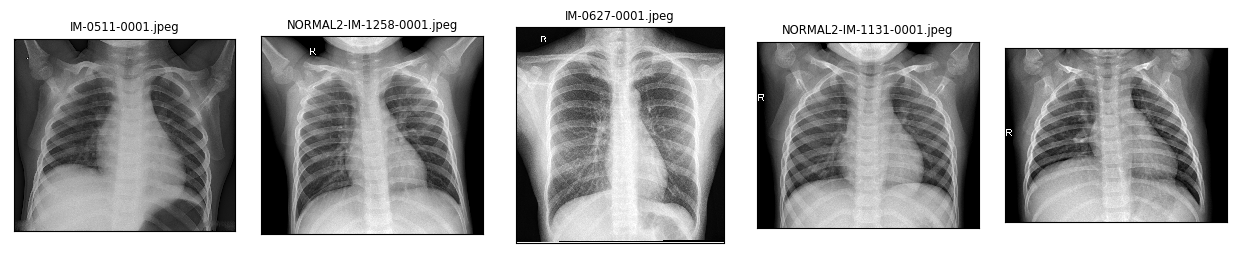


-------------------------------------------------------Pneumonia-------------------------------------------------------


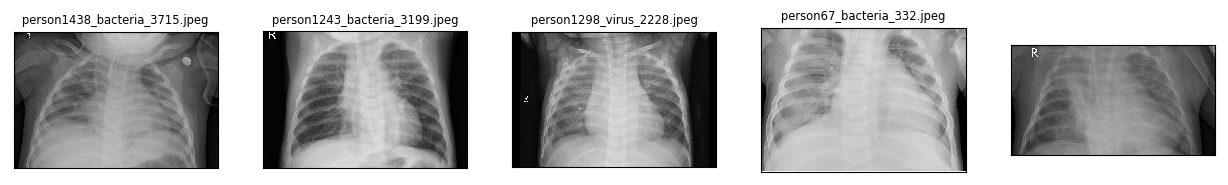


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [36]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

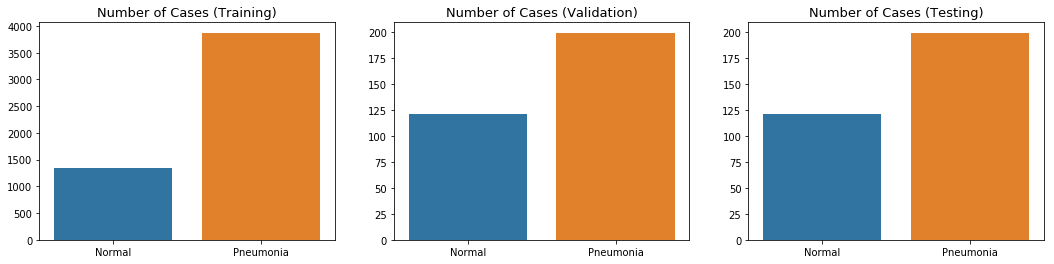

In [38]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

### Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and  Dataset 

In [41]:
rescale = 1./255

# batch_size = 32
batch_size = 64

# target_size = (150, 150)
target_size = (299, 299)
# color_mode = "grayscale"
color_mode = "rgb"
class_mode = "binary"
shuffle = True


# train_datagen = ImageDataGenerator(rescale=rescale,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)



train_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size)



# train_generator = train_datagen.flow_from_directory(
#     training_dir,
#     target_size=target_size,
#     color_mode=color_mode,
#     class_mode=class_mode,
#     batch_size=batch_size,
#     shuffle=shuffle)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


###  Training Files Configuration

In [42]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
# remove_empty_folders(main_log_dir, False)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Removing empty folder: data/output/models/2018-12-14 01-35-42


### Callbacks 

In [43]:
print("Settting Callbacks")
date_time(1)


monitor = 'val_loss'


checkpoint = ModelCheckpoint(
    model_file, 
    monitor=monitor, 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor=monitor,
    patience=10,
    verbose=1,
    restore_best_weights=True)

# tensorboard = TensorBoard(
#     log_dir=log_dir,
#     batch_size=batch_size)


tensorboard = TensorBoard(
    log_dir=log_dir,
    write_images=True,
    batch_size=batch_size)

# reduce_lr = ReduceLROnPlateau(
#     monitor=monitor, 
#     patience=3, 
#     verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor=monitor,
    patience=3,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks")
date_time(1)

Settting Callbacks
Set Callbacks


'Timestamp: 2018-12-14 04:10:18'

In [45]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
    # base_model = InceptionV3(weights=None, include_top=False, input_shape=(3, 150, 150))
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(128, activation='relu')(x)
    # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
    predictions = Dense(2, activation='sigmoid')(x) 
    # predictions = Dense(2, activation='softmax')(x) 
    
    

    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True
        
    
    model.summary()
        
    return model

### Training/Fine-Tuning Base Model-InceptionV3 for Fine-Tuning with New Class Labels

In [46]:
print("Gettting Model")
date_time(1)


# Get inception Model
#-----------------------------------------------------------------------------------------------------------------#
model = get_model()
#-----------------------------------------------------------------------------------------------------------------#

print("Got Model")
date_time(1)

Gettting Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, None, None, 2 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 6 192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, None, None, 6 192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, None, None, 6 192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 9 288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, None, None, 6 192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, None, 6 0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, None, None, 1 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, None, None, 7 0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 1 147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 1 576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, None, None, 1 576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, None, None, 1 0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, None, None, 7 0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, None, 1 147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, None, None, 1 576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, None, None, 1 576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, None, None, 3 0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, None, None, 1 576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, None, 3 0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 7 0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, None, 2 0           mixed10[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           dropout_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
batch_norm

'Timestamp: 2018-12-14 04:10:47'

In [ ]:
print("Starting Trainning Model")
date_time(1)

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)


# lr = 0.000001
# optimizer=optimizers.Adam(lr=lr)
# loss='categorical_crossentropy'

optimizer=optimizers.Adam()
loss='binary_crossentropy'

metrics=['accuracy']

model.compile(optimizer, loss=loss, metrics=metrics)


epochs = 100


history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
#     verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps)

print("Completed Model Trainning")
date_time(1)

Starting Trainning Model


### Model Performance Visualization over the Epochs

In [ ]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

### Test Saved Models

In [ ]:
dir_name = r"data/output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

In [ ]:
cur_dir =dir_name+dirs[2]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

In [ ]:
model_file = cur_dir+model_names[4]

print(model_file)

In [ ]:
cur_model = keras.models.load_model(model_file)

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score

result  = cur_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

In [ ]:
y_pred = cur_model.predict_generator(test_generator, steps=len(test_generator))     
y_pred = y_pred.argmax(axis=-1)

y_true=test_generator.classes
    
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100, "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100, "%"))


CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.show()
    
cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print(cls_report_print)

In [ ]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

### Visualization

In [ ]:
def show_predictions(y_img_batch, y_true, y_pred, image_file_name, plt, figure_map, sample=True):
    # figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
    fig, axs = plt.subplots(nrows=figure_map["rows"], ncols=figure_map["cols"], figsize=(figure_map["figsize_col"], figure_map["figsize_row"]),
                            dpi=figure_map["dpi"], facecolor=figure_map["facecolor"], edgecolor=figure_map["edgecolor"],
                            subplot_kw=figure_map["subplot_kw"])


    plt.rcParams.update({'axes.titlesize': figure_map["axes.titlesize"]})
    plt.subplots_adjust(hspace=figure_map["hspace"], wspace=figure_map["wspace"])
    
    m = {}
    
    length = len(y_true)

    for i in range(0, count):  
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(rows, cols, i+1)
        plt.imshow(y_img_batch[num])

        plt.xticks([])
        plt.yticks([])
        
        
        original = figure_map['class_map'][y_true[num]]
        predicted = figure_map['class_map'][y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%(true_label_title_prefix, original, "\n", pred_label_title_prefix, predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color=false_prediction_label_color)
            

        if update_image and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=dpi)

    plt.tight_layout()
    plt.show()



### Visualization

In [ ]:
figure_directory = "data/output/figures"
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

cols = 8
batch_size_t = len(y_true_batch)
if batch_size_t<8:
    cols = batch_size_t
    
rows = batch_size_t/cols

if batch_size_t%cols==0:
    rows = int(batch_size_t/cols)
else:
    rows = int(batch_size_t/cols)+1
    
count = batch_size_t
    
figsize_col = cols*2.5
figsize_row = rows*2.5


hspace = 0.5
wspace = 0.3

facecolor='w'
edgecolor='k'

titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org:  "
pred_label_title_prefix = "pred: "


dpi=100

update_image = True


if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    

batch_size_tmp = batch_size_t

figure_map = {}

figure_map["rows"]=rows
figure_map["cols"]=cols
figure_map["figsize_col"]=figsize_col
figure_map["figsize_row"]=figsize_row
figure_map["facecolor"]=facecolor
figure_map["edgecolor"]=edgecolor
figure_map["subplot_kw"]={'xticks': [], 'yticks': []}
figure_map["axes.titlesize"]=titlesize
figure_map["hspace"]=hspace
figure_map["wspace"]=wspace

figure_map["update_image"]=update_image
figure_map["dpi"]=dpi 
figure_map["count"]=count 
figure_map["batch_size_tmp"]=batch_size_t 

figure_map["true_label_title_prefix"]=true_label_title_prefix
figure_map["pred_label_title_prefix"]=pred_label_title_prefix
figure_map["false_prediction_label_color"]=false_prediction_label_color

figure_map['class_map'] = {v: k for k, v in test_generator.class_indices.items()}




#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

In [ ]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, image_file_name_batch, plt, figure_map, False)

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

In [ ]:
cols = 4
rows = 2

if batch_size_t<4:
    cols = 1
    

count = cols*rows
    
figsize_col = cols*2.5
figsize_row = rows*2.5


figure_map["rows"]=rows
figure_map["cols"]=cols
figure_map["figsize_col"]=figsize_col
figure_map["figsize_row"]=figsize_row
figure_map["count"]=count 
figure_map["batch_size_tmp"]=batch_size_t 


show_predictions(y_img_batch, y_true_batch, y_pred_batch, image_file_name_batch, plt, figure_map)